## Bitcoin Sentiment Analysis

This project, is a section of my final datascience bootcamp project where I built a model to forecast the future prices of Bitcoin. 

Information, particularly from mainstream media, twitter, and particular people like Elon Musk have been known to affect the price of crypto currency. 

The goal therefore for this particular project is to analyze bitcoin tweets, check it effect on the price and possibly use the sentiment analysis to make forecasts. 

### Import necessary libraries

In [1]:
import sys
import tweepy
import csv
import time
import numpy as np
from nltk.corpus import stopwords
import re
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
import string
from wordcloud import WordCloud, STOPWORDS
import nltk
import emoji
import warnings 
warnings.filterwarnings("ignore", category=DeprecationWarning)
sns.set()
%matplotlib inline


### Vader Sentiment Intensity Analyzer

In [2]:
import requests
import json
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

analyser = SentimentIntensityAnalyzer()
analyser.polarity_scores("Bitcoin is the BOMB!!!")

{'neg': 0.0, 'neu': 0.381, 'pos': 0.619, 'compound': 0.7074}

In [3]:
def sentiment_analyzer_scores(text):
    score = analyser.polarity_scores(text)
    lb = score['compound']
    if lb >= 0.05:
        return 1
    elif (lb > -0.05) and (lb < 0.05):
        return 0
    else:
        return -1
    
sentiment_analyzer_scores("Bitcoin is the BOMB!!!")

1

### Googletrans
Googletrans is a free and unlimited python library that implemented Google Translate API. This uses the Google Translate Ajax API to make calls to such methods as detect and translate.

In [4]:
from google_trans_new import google_translator  

translator = google_translator()  
text = translator.translate('Bitcoin ist die BOMBE',lang_tgt='en')  
print(text)
print("\n")
analyser.polarity_scores(text)

Bitcoin is the BOMB 




{'neg': 0.0, 'neu': 0.429, 'pos': 0.571, 'compound': 0.6124}

In [5]:
def sentiment_analyzer_scores(text, engl=True):
    if engl:
        trans = text
    else:
        trans = translator.translate(text,lang_tgt='en')

    score = analyser.polarity_scores(trans)
    lb = score['compound']
    if lb >= 0.05:
        return 1
    elif (lb > -0.05) and (lb < 0.05):
        return 0
    else:
        return -1
sentiment_analyzer_scores(text)

1

### Load saved bitcoin tweets

In [6]:
# Top 10000 tweets abouts bitcoin since 2021-01-06 (7 days from when project originally done)
# load and read saved btc tweets history from get_tweets.ipynb

df = pd.read_csv('tweet_text.csv')
df.drop(['text1', 'text2'], axis=1, inplace=True)
df.head

<bound method NDFrame.head of                  user                location  \
0           Toms_Vibe         Crown Point, IN   
1      DematerializeB                     NaN   
2        koda82900647                     NaN   
3           HiLlSnItE                   Lagos   
4           ahab_bull         London, England   
...               ...                     ...   
9995  oracletimesnews  British Virgin Islands   
9996    paulinebigbtc         Minneapolis, MN   
9997      freedom_21M             Chicago, IL   
9998           KFMH91         London, England   
9999        mxxhriego                     NaN   

                                                   text  
0     @d57heinz @gladstein @ejeancarroll @jack You'r...  
1     @gaborgurbacs @Adelgary @jack "#Bitcoin is gre...  
2      @bitcoin_brown From down under mate and let’s go  
3     First ever bitcoin giveaway by @1stBitCapital ...  
4     @CryptroCrypto So has China. More reason to le...  
...                              

### Clean Saved Tweets

In [7]:
def remove_pattern(input_txt, pattern):
    r = re.findall(pattern, input_txt)
    for i in r:
        input_txt = re.sub(i, '', input_txt)        
    return input_txt

def clean_tweets(lst):
    # remove twitter Return handles (RT @xxx:)
    lst = np.vectorize(remove_pattern)(lst, "RT @[\w]*:")
    # remove twitter handles (@xxx)
    lst = np.vectorize(remove_pattern)(lst, "@[\w]*")
    # remove URL links (httpxxx)
    lst = np.vectorize(remove_pattern)(lst, "https?://[A-Za-z0-9./]*")
    # remove special characters, numbers, punctuations (except for #)
    lst = np.core.defchararray.replace(lst, "[^a-zA-Z]", " ")
    return lst

def anl_tweets(lst, title='Tweets Sentiment_7days', engl=True ):
    sents = []
    for tw in lst:
        try:
            st = sentiment_analyzer_scores(tw, engl)
            sents.append(st)
        except:
            sents.append(0)
    ax = sns.distplot(
        sents,
        kde=False,
        bins=3)
    ax.set(xlabel='Negative                Neutral                 Positive',
           ylabel='#Tweets',
          title="Tweets of @"+title)
    return sents

def word_cloud(wd_list):
    stopwords = set(STOPWORDS)
    all_words = ' '.join([text for text in wd_list])
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        width=1600,
        height=800,
        random_state=21,
        colormap='jet',
        max_words=50,
        max_font_size=200).generate(all_words)
    plt.figure(figsize=(12, 10))
    plt.axis('off')
    plt.imshow(wordcloud, interpolation="bilinear");

C:\Users\pbamo\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


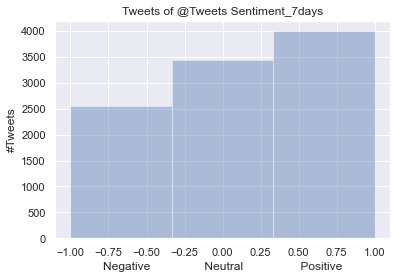

In [8]:
df['text'] = clean_tweets(df['text'])
df['text1']=df['text'].replace('\*','',regex=True)
df['text2'] = df['text'].str.replace('[^\w\s#@/:%.,_-]', '', flags=re.UNICODE)
df['sent'] = anl_tweets(df.text2)
plt.savefig("Images/Tweets_Sentiment_7days.png")

### Word Cloud

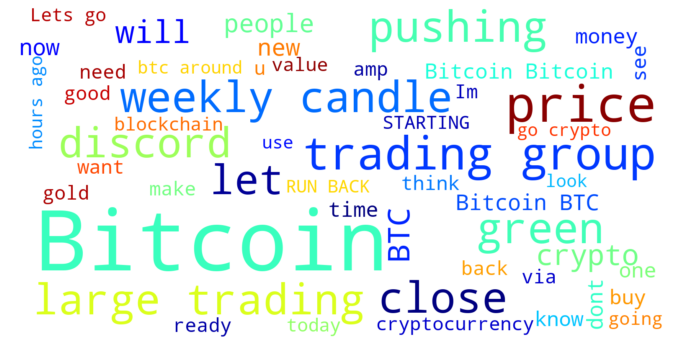

In [9]:
fig = word_cloud(df.text2)
#wordcloud.to_file("Images/Tweets_7days.png")
plt.savefig("Images/wordcloud_Tweets_7days.png")

### Exploring positives and negatives tweets

In [10]:
def hashtag_extract(x):
    hashtags = []
    # Loop over the words in the tweet
    for i in x:
        ht = re.findall(r"#(\w+)", i)
        hashtags.append(ht)
    return hashtags

# extracting hashtags from positive tweets
HT_positive = hashtag_extract(df['text'][df['sent'] == 1])

# extracting hashtags from negative tweets
HT_negative = hashtag_extract(df['text'][df['sent'] == -1])

# extracting hashtags from neutral tweets
HT_neutral = hashtag_extract(df['text'][df['sent'] == 0])

# unnesting list
HT_positive = sum(HT_positive,[])
HT_negative = sum(HT_negative,[])
HT_neutral = sum(HT_neutral,[])

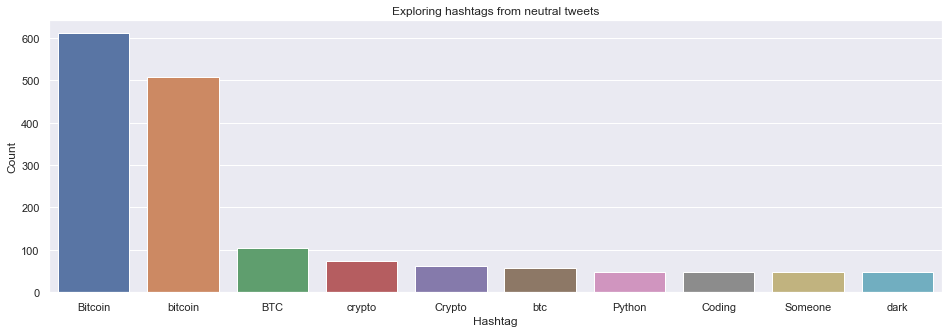

In [23]:
a = nltk.FreqDist(HT_neutral)
d = pd.DataFrame({'Hashtag':list(a.keys()), 'Count':list(a.values())})
# selecting top 10 most frequent hashtags
d = d.nlargest(columns='Count', n=10)
plt.figure(figsize=(16,5))
ax = sns.barplot(data=d, x="Hashtag", y="Count")
ax.set(ylabel = 'Count', title= 'Exploring hashtags from neutral tweets')
plt.savefig("Images/Neutral_Tweets_Hashtag_7days.png")
plt.show()

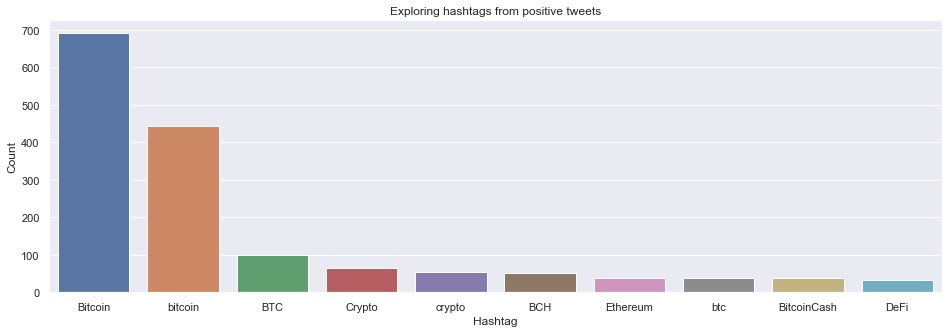

In [24]:
a = nltk.FreqDist(HT_positive)
d = pd.DataFrame({'Hashtag':list(a.keys()), 'Count':list(a.values())})
# selecting top 10 most frequent hashtags
d = d.nlargest(columns='Count', n=10)
plt.figure(figsize=(16,5))
ax = sns.barplot(data=d, x="Hashtag", y="Count")
ax.set(ylabel = 'Count', title= 'Exploring hashtags from positive tweets')
plt.savefig("Images/Positive_Tweets_Hashtag_7days.png")
plt.show()

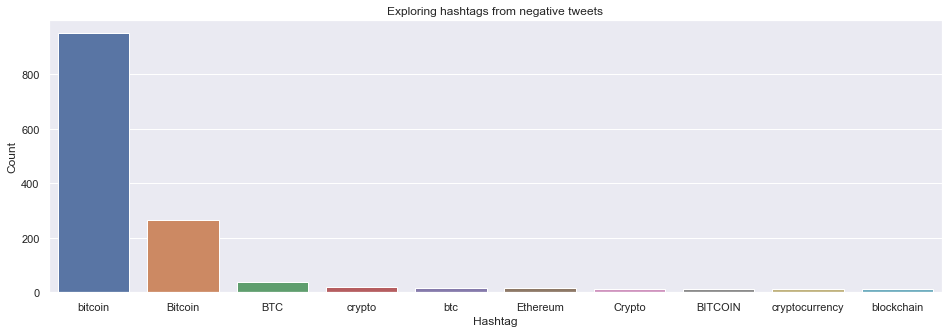

In [25]:
a = nltk.FreqDist(HT_negative)
d = pd.DataFrame({'Hashtag':list(a.keys()), 'Count':list(a.values())})
# selecting top 10 most frequent hashtags
d = d.nlargest(columns='Count', n=10)
plt.figure(figsize=(16,5))
ax = sns.barplot(data=d, x="Hashtag", y="Count")
ax.set(ylabel = 'Count', title= 'Exploring hashtags from negative tweets')
plt.savefig("Images/Negative_Tweets_Hashtag_7days.png")
plt.show()

In [14]:
df

,user,location,text,text1,text2,sent
0,Toms_Vibe,"Crown Point, IN",You're probably right. Although I think th...,You're probably right. Although I think th...,Youre probably right. Although I think tho...,0
1,DematerializeB,NaN,"""#Bitcoin is great"" is a natural extension ...","""#Bitcoin is great"" is a natural extension ...",#Bitcoin is great is a natural extension of...,1
2,koda82900647,NaN,From down under mate and let’s go,From down under mate and let’s go,From down under mate and lets go,0
3,HiLlSnItE,Lagos,First ever bitcoin giveaway by \nDon't sleep ...,First ever bitcoin giveaway by \nDon't sleep ...,First ever bitcoin giveaway by \nDont sleep o...,0
4,ahab_bull,"London, England",So has China. More reason to leep bitcoin,So has China. More reason to leep bitcoin,So has China. More reason to leep bitcoin,0
...,...,...,...,...,...,...
9995,oracletimesnews,British Virgin Islands,New SEC Chief Will Boost Bitcoin – What About ...,New SEC Chief Will Boost Bitcoin – What About ...,New SEC Chief Will Boost Bitcoin What About X...,1
9996,paulinebigbtc,"Minneapolis, MN","The value chain needs hardware, not just softw...","The value chain needs hardware, not just softw...","The value chain needs hardware, not just softw...",1
9997,freedom_21M,"Chicago, IL","the score can vary between 1.00 and 5.00, the ...","the score can vary between 1.00 and 5.00, the ...","the score can vary between 1.00 and 5.00, the ...",1
9998,KFMH91,"London, England",Whilst bitcoin uses alot of power it can off...,Whilst bitcoin uses alot of power it can off...,Whilst bitcoin uses alot of power it can off...,0


### Get location of Tweets

from geopy.exc import GeocoderTimedOut
from geopy.geocoders import Nominatim   

geolocator=Nominatim(user_agent="Your_app-name")    

City_name=geolocator.geocode("Whitefield,India")

Lat = City_name.latitude 
lon=City_name.longitude

print( City_name,lon,Lat)

In [22]:
from geopy.exc import GeocoderTimedOut
from geopy.geocoders import Nominatim
import gmplot

#geolocator = Nominatim()
#geolocator = Nominatim(user_agent="my-application")
#user_agent: geopy.geocoders.options.default_user_agent = "my-application"

geolocator=Nominatim(user_agent="Your_app-name")

# Go through all tweets and add locations to 'coordinates' dictionary
coordinates = {'latitude': [], 'longitude': []}
for count, user_loc in enumerate(df.location):
    try:
        location = geolocator.geocode(user_loc)
        
        # If coordinates are found for location
        if location:
            coordinates['latitude'].append(location.latitude)
            coordinates['longitude'].append(location.longitude)
            
    # If too many connection requests
    except:
        pass
    
# Instantiate and center a GoogleMapPlotter object to show our map
gmap = gmplot.GoogleMapPlotter(30, 0, 3)

# Insert points on the map passing a list of latitudes and longitudes
gmap.heatmap(coordinates['latitude'], coordinates['longitude'], radius=20)

# Save the map to html file
gmap.draw("Images/btc_heatmap.html")